In [1]:
# loading dependencies


import os
import glob
import csv
from pathlib import Path
from umi_tools import UMIClusterer
import matplotlib.pyplot as plt
import json
import requests
from itertools import combinations
from scipy.stats import ttest_ind
import sys, subprocess, glob, os, shutil, re, importlib, csv, json
from subprocess import call
import collections
from collections import Counter
from Bio import SeqIO
from Bio import Seq
import Bio.Phylo
import pandas as pd
import numpy as np
import rpy2
from scipy import stats
#%load_ext rpy2.ipython
%reload_ext rpy2.ipython
from io import BytesIO as csio
import requests
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
import matplotlib as mpl
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
#matplotlib.use('TkAgg')
%matplotlib inline

## Compiling our iSNVs into a single dataframe

In [2]:
folder='vcf_intersection/'

#save column with filename name (hence, ferret ID, timepoint and replicate)
for file in Path(folder).glob('*.csv'):
    df=pd.read_csv(file, sep='\t', index_col=None, header=0)
    df['filename'] = os.path.basename(file)
    df.to_csv(file.with_suffix('.csv'), index = False, sep='\t')



In [3]:
#concatenate all Anhui files into a single dataframe
folder='vcf_intersection/'
all_files = glob.glob(os.path.join(folder, "Anhui*.csv")) 
df_from_each_file = (pd.read_csv(f, sep='\t') for f in all_files)
concatenated_df = pd.concat(df_from_each_file, ignore_index=True)
concatenated_df.to_csv('Anhui_concatenated_all_snps.csv', sep='\t', index=False)

#cleaning dataframe
df = pd.read_csv('Anhui_concatenated_all_snps.csv', sep='\t')
df_sub = df.SNP.str.split("_", expand=True)
df_sub = df_sub.rename(columns={0: 'gene', 1: 'nt_POS', 2: 'annotation'})
df["gene"] = df_sub['gene']
df["nt_POS"] = df_sub['nt_POS']
df["annotation"] = df_sub['annotation']
#df = df[df['gene'] == 'HA']
df['filename'] = df['filename'].apply(str)
df_file = df.filename.str.split(".", expand=True)
df_animal = df_file[0]
df_animal_subset = pd.DataFrame(df_animal)
df['Sample'] = df_animal_subset
df = df.rename(columns={'POS_x': 'POS'})
df.POS = df.POS.astype(int)
df['REF'] = df['nt_POS'].str[:1]
df['ALT'] = df['nt_POS'].str[-1:]
df = df[["gene", 'annotation', 'POS', 'REF', 'ALT', 'SNP', 'Sample']]
df = df[df['annotation'] != 'syn']
df = df.drop_duplicates(subset='SNP', keep="first")
df = df.sort_values('POS', ascending=True)
df.to_csv('final_Anhui_cleaned_snps.csv', sep='\t', index=False)
print("Total number of Anhui mutations is: ", len(df))



Total number of Anhui mutations is:  165


In [4]:
#concatenate all GD3 files into a single dataframe
folder='vcf_intersection/'
all_files = glob.glob(os.path.join(folder, "GD3*.csv")) 
df_from_each_file = (pd.read_csv(f, sep='\t') for f in all_files)
concatenated_df = pd.concat(df_from_each_file, ignore_index=True)
concatenated_df.to_csv('GD3_concatenated_all_snps.csv', sep='\t', index=False)

#cleaning dataframe
df = pd.read_csv('GD3_concatenated_all_snps.csv', sep='\t')
df_sub = df.SNP.str.split("_", expand=True)
df_sub = df_sub.rename(columns={0: 'gene', 1: 'nt_POS', 2: 'annotation'})
df["gene"] = df_sub['gene']
df["nt_POS"] = df_sub['nt_POS']
df["annotation"] = df_sub['annotation']
#df = df[df['gene'] == 'HA']
df['filename'] = df['filename'].apply(str)
df_file = df.filename.str.split(".", expand=True)
df_animal = df_file[0]
df_animal_subset = pd.DataFrame(df_animal)
df['Sample'] = df_animal_subset
df = df.rename(columns={'POS_x': 'POS'})
df.POS = df.POS.astype(int)
df['REF'] = df['nt_POS'].str[:1]
df['ALT'] = df['nt_POS'].str[-1:]
df = df[df['annotation'] != 'syn']
df = df.drop_duplicates(subset='SNP', keep="first")
df = df.sort_values('POS', ascending=True)
df = df[["gene", 'annotation', 'POS', 'REF', 'ALT', 'SNP', 'Sample']]
df.to_csv('final_GD3_cleaned_snps.csv', sep='\t', index=False)
print("Total number of GD3 mutations is: ", len(df))


Total number of GD3 mutations is:  97


In [5]:
#creating a single file wth everything just i case we need it

anhui = pd.read_csv('final_Anhui_cleaned_snps.csv', sep='\t')
gd3 = pd.read_csv('final_GD3_cleaned_snps.csv', sep='\t')
data = [anhui, gd3]

final = pd.concat(data, ignore_index=True)

final.to_csv('final_all_cleaned_snps.csv', sep='\t', index=False)

## Global Surveillance Analysis
##### Callling the list of Nexstrain mutations and cleaning the data

In [406]:
path_to_global_isnvs = 'full_nextstrain_mutations_table.tsv'
global_isnv = pd.read_csv(path_to_global_isnvs, sep='\t')

# subsetting for the columns we need

global_isnv = global_isnv[['coding_region_change', 'avian_mutations',
       'human_mutations', 'gene', 'region_gene', 'site']]


global_isnv['gene'].unique()

array(['HA', 'PA', nan, 'PB1', 'PB2', 'MP', 'NS', 'NP'], dtype=object)

In [407]:
global_isnv['gene'] = global_isnv['gene'].fillna('NA1')
global_isnv['gene'] = global_isnv['gene'].str.replace('NA1', 'NA')


global_isnv = global_isnv.drop_duplicates(subset='region_gene', keep="first")
print(global_isnv['gene'].unique())

print("\n Total number of mutations used for the analysis is: ", len(global_isnv['coding_region_change']))

['HA' 'PA' 'NA' 'PB1' 'PB2' 'MP' 'NS' 'NP']

 Total number of mutations used for the analysis is:  2071


### Now we clean our iSNVs so that we can later merge with the Nextrsin data for each group (Anhui and GD3)

In [408]:
anhui = 'final_Anhui_cleaned_snps.csv'
gd3 = 'final_GD3_cleaned_snps.csv'

snv_anhui = pd.read_csv(anhui, sep='\t')
snv_gd3 = pd.read_csv(gd3, sep='\t')

print("Number of Anhui/1 iSNVs is: ", len(snv_anhui))
print("Number of GD/3 iSNVs is: ", len(snv_gd3))
snv_anhui['gene'].unique()

Number of Anhui/1 iSNVs is:  165
Number of GD/3 iSNVs is:  97


array(['NEP', 'NS1', 'PA', 'PB2', nan, 'PB1', 'NP', 'HA', 'M1', 'M2'],
      dtype=object)

In [409]:
# NA is being read as nan
# We need to correct this and change the name of the gene segments to only focus on the 8 major proteins

snv_anhui['gene'] = snv_anhui['gene'].str.replace('M1', 'MP')
snv_anhui['gene'] = snv_anhui['gene'].str.replace('M2', 'MP')
snv_anhui['gene'] = snv_anhui['gene'].str.replace('NEP', 'NP')
snv_anhui['gene'] = snv_anhui['gene'].str.replace('NS1', 'NS')
snv_anhui['gene'] = snv_anhui['gene'].str.replace('NS2', 'NS')
snv_anhui['gene'] = snv_anhui['gene'].fillna('NA1')
snv_anhui['gene'] = snv_anhui['gene'].str.replace('NA1', 'NA')

snv_gd3['gene'] = snv_gd3['gene'].str.replace('M1', 'MP')
snv_gd3['gene'] = snv_gd3['gene'].str.replace('M2', 'MP')
snv_gd3['gene'] = snv_gd3['gene'].str.replace('NEP', 'NP')
snv_gd3['gene'] = snv_gd3['gene'].str.replace('NS1', 'NS')
snv_gd3['gene'] = snv_gd3['gene'].str.replace('NS2', 'NS')
snv_gd3['gene'] = snv_gd3['gene'].fillna('NA1')
snv_gd3['gene'] = snv_gd3['gene'].str.replace('NA1', 'NA')



In [410]:
# Looking good

print(snv_anhui['gene'].unique())

['NP' 'NS' 'PA' 'PB2' 'NA' 'PB1' 'HA' 'MP']


In [411]:
# subsetting both lists to what we need: coding region, sample and gene 

snv_anhui_sub = snv_anhui[['annotation', 'Sample', 'gene']]
snv_anhui_sub['site'] = snv_anhui_sub['gene'] + " " + snv_anhui_sub['annotation']
snv_anhui_sub = snv_anhui_sub.rename(columns = {'annotation':'coding_region_change'})

snv_gd3_sub = snv_gd3[['annotation', 'Sample', 'gene']]
snv_gd3_sub['site'] = snv_gd3_sub['gene'] + " " + snv_gd3_sub['annotation']
snv_gd3_sub = snv_gd3_sub.rename(columns = {'annotation':'coding_region_change'})
#snv_gd3_sub.head(60)

/var/folders/4h/6r4ld7rx7696y7ff000141z40000gp/T/ipykernel_1280/730415670.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snv_anhui_sub['site'] = snv_anhui_sub['gene'] + " " + snv_anhui_sub['annotation']
/var/folders/4h/6r4ld7rx7696y7ff000141z40000gp/T/ipykernel_1280/730415670.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snv_gd3_sub['site'] = snv_gd3_sub['gene'] + " " + snv_gd3_sub['annotation']


## Merging Anhui and GD3 with the Nextstrain list and enmerating occurrences

In [412]:
merged_data_anhui = pd.DataFrame(snv_anhui_sub[['coding_region_change', 'gene', 'Sample', 'site']]).merge(global_isnv, how='left', on=['site', 'coding_region_change', 'gene'])
merged_data_anhui = merged_data_anhui.drop_duplicates()
merged_data_anhui = merged_data_anhui.drop_duplicates(subset='site', keep="first")
merged_data_anhui = merged_data_anhui.fillna(0)
#merged_data_anhui['site2'] = merged_data_anhui.coding_region_change.str[1:]

# if the iSNV has at least one mutation in Nextstrain tree, label it as human, avian, both
# else label as 'none'

#list of conditions

conditions = [
    (merged_data_anhui['avian_mutations'] != 0) & (merged_data_anhui['human_mutations'] == 0),
    (merged_data_anhui['human_mutations'] != 0) & (merged_data_anhui['avian_mutations'] == 0),
    (merged_data_anhui['avian_mutations'] >= 1) & (merged_data_anhui['human_mutations'] >= 1),
    (merged_data_anhui['avian_mutations'] == 0) & (merged_data_anhui['human_mutations'] == 0)]

# list of values we want to assign
values = ['avian', 'human', 'both', 'none']

merged_data_anhui['host'] = np.select(conditions, values)

#keeping only those that have at least one occurrence on global samples
merged_data_anhui = merged_data_anhui[merged_data_anhui['host'] != 'none']



#working on those with values in both human and avian hosts
both_values_anhui = merged_data_anhui[merged_data_anhui['host'] == 'both']

for value in both_values_anhui['host']:
     
    both_values_anhui['total_occurrences'] = both_values_anhui['human_mutations'] + both_values_anhui['avian_mutations']
    #both_values_anhui['avian_mutations'] = both_values_anhui['avian_mutations'].values[:] = 0

print("Number of Anhui iSNVs in global surveillance is: ", len(merged_data_anhui))
print("Confirming that NA is not being read as nsn: ", merged_data_anhui['gene'].unique())


Number of Anhui iSNVs in global surveillance is:  77
Confirming that NA is not being read as nsn:  ['NS' 'PA' 'PB2' 'NA' 'NP' 'HA' 'PB1' 'MP']


/var/folders/4h/6r4ld7rx7696y7ff000141z40000gp/T/ipykernel_1280/3743863457.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both_values_anhui['total_occurrences'] = both_values_anhui['human_mutations'] + both_values_anhui['avian_mutations']


In [416]:
#merged_data_anhui separated by gene

print("The total number of unique Anhui mutations is :", len(merged_data_anhui))
print("The total number of unique Anhui mutations for HA is :", len(merged_data_anhui[merged_data_anhui['gene']=='HA']))
print("The total number of unique Anhui mutations for NA is :", len(merged_data_anhui[merged_data_anhui['gene']=='NA']))
print("The total number of unique Anhui mutations for PA is :", len(merged_data_anhui[merged_data_anhui['gene']=='PA']))
print("The total number of unique Anhui mutations for NP is :", len(merged_data_anhui[merged_data_anhui['gene']=='NP']))
print("The total number of unique Anhui mutations for MP is :", len(merged_data_anhui[merged_data_anhui['gene']=='MP']))
print("The total number of unique Anhui mutations for NS is :", len(merged_data_anhui[merged_data_anhui['gene']=='NS']))
print("The total number of unique Anhui mutations for PB1 is :", len(merged_data_anhui[merged_data_anhui['gene']=='PB1']))
print("The total number of unique Anhui mutations for PB2 is :", len(merged_data_anhui[merged_data_anhui['gene']=='PB2']))
print("Total number of human samples: ", len(merged_data_anhui[merged_data_anhui['host']=='human']))
print("Total number of avian samples: ", len(merged_data_anhui[merged_data_anhui['host']=='avian']))
print("Total number of samples in both human and birds: ", len(merged_data_anhui[merged_data_anhui['host']=='both']))


The total number of unique Anhui mutations is : 77
The total number of unique Anhui mutations for HA is : 14
The total number of unique Anhui mutations for NA is : 8
The total number of unique Anhui mutations for PA is : 10
The total number of unique Anhui mutations for NP is : 8
The total number of unique Anhui mutations for MP is : 4
The total number of unique Anhui mutations for NS is : 6
The total number of unique Anhui mutations for PB1 is : 8
The total number of unique Anhui mutations for PB2 is : 19
Total number of human samples:  49
Total number of avian samples:  9
Total number of samples in both human and birds:  19


In [420]:
merged_anhui_human = merged_data_anhui[merged_data_anhui['host']=='human']

print("The total number of unique anhui mutations is :", len(merged_anhui_human))
print("The total number of unique anhui mutations for HA is :", len(merged_anhui_human[merged_anhui_human['gene']=='HA']))
print("The total number of unique anhui mutations for NA is :", len(merged_anhui_human[merged_anhui_human['gene']=='NA']))
print("The total number of unique anhui mutations for PA is :", len(merged_anhui_human[merged_anhui_human['gene']=='PA']))
print("The total number of unique anhui mutations for NP is :", len(merged_anhui_human[merged_anhui_human['gene']=='NP']))
print("The total number of unique anhui mutations for MP is :", len(merged_anhui_human[merged_anhui_human['gene']=='MP']))
print("The total number of unique anhui mutations for NS is :", len(merged_anhui_human[merged_anhui_human['gene']=='NS']))
print("The total number of unique anhui mutations for PB1 is :", len(merged_anhui_human[merged_anhui_human['gene']=='PB1']))
print("The total number of unique anhui mutations for PB2 is :", len(merged_anhui_human[merged_anhui_human['gene']=='PB2']))

print('\n')

merged_anhui_avian = merged_data_anhui[merged_data_anhui['host']=='avian']

print("The total number of unique anhui mutations is :", len(merged_anhui_avian))
print("The total number of unique anhui mutations for HA is :", len(merged_anhui_avian[merged_anhui_avian['gene']=='HA']))
print("The total number of unique anhui mutations for NA is :", len(merged_anhui_avian[merged_anhui_avian['gene']=='NA']))
print("The total number of unique anhui mutations for PA is :", len(merged_anhui_avian[merged_anhui_avian['gene']=='PA']))
print("The total number of unique anhui mutations for NP is :", len(merged_anhui_avian[merged_anhui_avian['gene']=='NP']))
print("The total number of unique anhui mutations for MP is :", len(merged_anhui_avian[merged_anhui_avian['gene']=='MP']))
print("The total number of unique anhui mutations for NS is :", len(merged_anhui_avian[merged_anhui_avian['gene']=='NS']))
print("The total number of unique anhui mutations for PB1 is :", len(merged_anhui_avian[merged_anhui_avian['gene']=='PB1']))
print("The total number of unique anhui mutations for PB2 is :", len(merged_anhui_avian[merged_anhui_avian['gene']=='PB2']))

print('\n')

merged_anhui_both = merged_data_anhui[merged_data_anhui['host']=='both']

print("The total number of unique anhui mutations is :", len(merged_anhui_both))
print("The total number of unique anhui mutations for HA is :", len(merged_anhui_both[merged_anhui_both['gene']=='HA']))
print("The total number of unique anhui mutations for NA is :", len(merged_anhui_both[merged_anhui_both['gene']=='NA']))
print("The total number of unique anhui mutations for PA is :", len(merged_anhui_both[merged_anhui_both['gene']=='PA']))
print("The total number of unique anhui mutations for NP is :", len(merged_anhui_both[merged_anhui_both['gene']=='NP']))
print("The total number of unique anhui mutations for MP is :", len(merged_anhui_both[merged_anhui_both['gene']=='MP']))
print("The total number of unique anhui mutations for NS is :", len(merged_anhui_both[merged_anhui_both['gene']=='NS']))
print("The total number of unique anhui mutations for PB1 is :", len(merged_anhui_both[merged_anhui_both['gene']=='PB1']))
print("The total number of unique anhui mutations for PB2 is :", len(merged_anhui_both[merged_anhui_both['gene']=='PB2']))


The total number of unique anhui mutations is : 49
The total number of unique anhui mutations for HA is : 5
The total number of unique anhui mutations for NA is : 5
The total number of unique anhui mutations for PA is : 5
The total number of unique anhui mutations for NP is : 5
The total number of unique anhui mutations for MP is : 4
The total number of unique anhui mutations for NS is : 3
The total number of unique anhui mutations for PB1 is : 6
The total number of unique anhui mutations for PB2 is : 16


The total number of unique anhui mutations is : 9
The total number of unique anhui mutations for HA is : 5
The total number of unique anhui mutations for NA is : 3
The total number of unique anhui mutations for PA is : 1
The total number of unique anhui mutations for NP is : 0
The total number of unique anhui mutations for MP is : 0
The total number of unique anhui mutations for NS is : 0
The total number of unique anhui mutations for PB1 is : 0
The total number of unique anhui mutat

In [417]:
merged_data_gd3 = pd.DataFrame(snv_gd3_sub[['coding_region_change', 'gene', 'Sample', 'site']]).merge(global_isnv, how='left', on=['site', 'coding_region_change', 'gene'])
merged_data_gd3 = merged_data_gd3.drop_duplicates()
merged_data_gd3 = merged_data_gd3.drop_duplicates(subset='site', keep="first")
merged_data_gd3 = merged_data_gd3.fillna(0)
#merged_data_gd3['site2'] = merged_data_gd3.coding_region_change.str[1:]

# if the iSNV has at least one mutation in Nextstrain tree, label it as human, avian, both
# else label as 'none'

#list of conditions

conditions = [
    (merged_data_gd3['avian_mutations'] != 0) & (merged_data_gd3['human_mutations'] == 0),
    (merged_data_gd3['human_mutations'] != 0) & (merged_data_gd3['avian_mutations'] == 0),
    (merged_data_gd3['avian_mutations'] >= 1) & (merged_data_gd3['human_mutations'] >= 1),
    (merged_data_gd3['avian_mutations'] == 0) & (merged_data_gd3['human_mutations'] == 0)]

# list of values we want to assign
values = ['avian', 'human', 'both', 'none']

merged_data_gd3['host'] = np.select(conditions, values)

#keeping only those that have at least one occurrence on global samples
merged_data_gd3 = merged_data_gd3[merged_data_gd3['host'] != 'none']



#working on those with values in both human and avian hosts
both_values_gd3 = merged_data_gd3[merged_data_gd3['host'] == 'both']

for value in both_values_gd3['host']:
     
    both_values_gd3['total_occurrences'] = both_values_gd3['human_mutations'] + both_values_gd3['avian_mutations']
    #both_values_gd3['avian_mutations'] = both_values_gd3['avian_mutations'].values[:] = 0

print("Number of GD/3 iSNVs in global surveillance is: ", len(merged_data_gd3))
print("Confirming that NA is not being read as nsn: ", merged_data_gd3['gene'].unique())

Number of GD/3 iSNVs in global surveillance is:  35
Confirming that NA is not being read as nsn:  ['NP' 'NS' 'HA' 'PB2' 'PA' 'MP' 'PB1' 'NA']


/var/folders/4h/6r4ld7rx7696y7ff000141z40000gp/T/ipykernel_1280/33093997.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both_values_gd3['total_occurrences'] = both_values_gd3['human_mutations'] + both_values_gd3['avian_mutations']


In [418]:
#merged_data_gd3 separated by gene

print("The total number of unique gd3 mutations is :", len(merged_data_gd3))
print("The total number of unique gd3 mutations for HA is :", len(merged_data_gd3[merged_data_gd3['gene']=='HA']))
print("The total number of unique gd3 mutations for NA is :", len(merged_data_gd3[merged_data_gd3['gene']=='NA']))
print("The total number of unique gd3 mutations for PA is :", len(merged_data_gd3[merged_data_gd3['gene']=='PA']))
print("The total number of unique gd3 mutations for NP is :", len(merged_data_gd3[merged_data_gd3['gene']=='NP']))
print("The total number of unique gd3 mutations for MP is :", len(merged_data_gd3[merged_data_gd3['gene']=='MP']))
print("The total number of unique gd3 mutations for NS is :", len(merged_data_gd3[merged_data_gd3['gene']=='NS']))
print("The total number of unique gd3 mutations for PB1 is :", len(merged_data_gd3[merged_data_gd3['gene']=='PB1']))
print("The total number of unique gd3 mutations for PB2 is :", len(merged_data_gd3[merged_data_gd3['gene']=='PB2']))
print("Total number of human samples: ", len(merged_data_gd3[merged_data_gd3['host']=='human']))
print("Total number of avian samples: ", len(merged_data_gd3[merged_data_gd3['host']=='avian']))
print("Total number of samples in both human and birds: ", len(merged_data_gd3[merged_data_gd3['host']=='both']))



The total number of unique gd3 mutations is : 35
The total number of unique gd3 mutations for HA is : 5
The total number of unique gd3 mutations for NA is : 1
The total number of unique gd3 mutations for PA is : 5
The total number of unique gd3 mutations for NP is : 4
The total number of unique gd3 mutations for MP is : 4
The total number of unique gd3 mutations for NS is : 8
The total number of unique gd3 mutations for PB1 is : 5
The total number of unique gd3 mutations for PB2 is : 3
Total number of human samples:  20
Total number of avian samples:  8
Total number of samples in both human and birds:  7


In [421]:
merged_gd3_human = merged_data_gd3[merged_data_gd3['host']=='human']

print("The total number of unique gd3 mutations is :", len(merged_gd3_human))
print("The total number of unique gd3 mutations for HA is :", len(merged_gd3_human[merged_gd3_human['gene']=='HA']))
print("The total number of unique gd3 mutations for NA is :", len(merged_gd3_human[merged_gd3_human['gene']=='NA']))
print("The total number of unique gd3 mutations for PA is :", len(merged_gd3_human[merged_gd3_human['gene']=='PA']))
print("The total number of unique gd3 mutations for NP is :", len(merged_gd3_human[merged_gd3_human['gene']=='NP']))
print("The total number of unique gd3 mutations for MP is :", len(merged_gd3_human[merged_gd3_human['gene']=='MP']))
print("The total number of unique gd3 mutations for NS is :", len(merged_gd3_human[merged_gd3_human['gene']=='NS']))
print("The total number of unique gd3 mutations for PB1 is :", len(merged_gd3_human[merged_gd3_human['gene']=='PB1']))
print("The total number of unique gd3 mutations for PB2 is :", len(merged_gd3_human[merged_gd3_human['gene']=='PB2']))

print('/n')

merged_gd3_avian = merged_data_gd3[merged_data_gd3['host']=='avian']

print("The total number of unique gd3 mutations is :", len(merged_gd3_avian))
print("The total number of unique gd3 mutations for HA is :", len(merged_gd3_avian[merged_gd3_avian['gene']=='HA']))
print("The total number of unique gd3 mutations for NA is :", len(merged_gd3_avian[merged_gd3_avian['gene']=='NA']))
print("The total number of unique gd3 mutations for PA is :", len(merged_gd3_avian[merged_gd3_avian['gene']=='PA']))
print("The total number of unique gd3 mutations for NP is :", len(merged_gd3_avian[merged_gd3_avian['gene']=='NP']))
print("The total number of unique gd3 mutations for MP is :", len(merged_gd3_avian[merged_gd3_avian['gene']=='MP']))
print("The total number of unique gd3 mutations for NS is :", len(merged_gd3_avian[merged_gd3_avian['gene']=='NS']))
print("The total number of unique gd3 mutations for PB1 is :", len(merged_gd3_avian[merged_gd3_avian['gene']=='PB1']))
print("The total number of unique gd3 mutations for PB2 is :", len(merged_gd3_avian[merged_gd3_avian['gene']=='PB2']))

print('/n')

merged_gd3_both = merged_data_gd3[merged_data_gd3['host']=='both']

print("The total number of unique gd3 mutations is :", len(merged_gd3_both))
print("The total number of unique gd3 mutations for HA is :", len(merged_gd3_both[merged_gd3_both['gene']=='HA']))
print("The total number of unique gd3 mutations for NA is :", len(merged_gd3_both[merged_gd3_both['gene']=='NA']))
print("The total number of unique gd3 mutations for PA is :", len(merged_gd3_both[merged_gd3_both['gene']=='PA']))
print("The total number of unique gd3 mutations for NP is :", len(merged_gd3_both[merged_gd3_both['gene']=='NP']))
print("The total number of unique gd3 mutations for MP is :", len(merged_gd3_both[merged_gd3_both['gene']=='MP']))
print("The total number of unique gd3 mutations for NS is :", len(merged_gd3_both[merged_gd3_both['gene']=='NS']))
print("The total number of unique gd3 mutations for PB1 is :", len(merged_gd3_both[merged_gd3_both['gene']=='PB1']))
print("The total number of unique gd3 mutations for PB2 is :", len(merged_gd3_both[merged_gd3_both['gene']=='PB2']))



The total number of unique gd3 mutations is : 20
The total number of unique gd3 mutations for HA is : 1
The total number of unique gd3 mutations for NA is : 1
The total number of unique gd3 mutations for PA is : 3
The total number of unique gd3 mutations for NP is : 1
The total number of unique gd3 mutations for MP is : 2
The total number of unique gd3 mutations for NS is : 5
The total number of unique gd3 mutations for PB1 is : 5
The total number of unique gd3 mutations for PB2 is : 2
/n
The total number of unique gd3 mutations is : 8
The total number of unique gd3 mutations for HA is : 2
The total number of unique gd3 mutations for NA is : 0
The total number of unique gd3 mutations for PA is : 1
The total number of unique gd3 mutations for NP is : 1
The total number of unique gd3 mutations for MP is : 1
The total number of unique gd3 mutations for NS is : 2
The total number of unique gd3 mutations for PB1 is : 0
The total number of unique gd3 mutations for PB2 is : 1
/n
The total num

In [336]:
## Adding a new column to count total number of occurrences

melted_anhui = merged_data_anhui[['site', 'gene', 'avian_mutations', 'human_mutations']]
melted_anhui = melted_anhui.sort_values(by=['gene'], ascending=[False])
melted_anhui = melted_anhui.rename(columns = {'avian_mutations':'avian_ocurrences', 'human_mutations':'human_ocurrences'})
melted_anhui['total_ocurrences'] = melted_anhui['human_ocurrences'] + melted_anhui['avian_ocurrences']

melted_gd3 = merged_data_gd3[['site', 'gene', 'avian_mutations', 'human_mutations']]
melted_gd3 = melted_gd3.sort_values(by=['gene'], ascending=[False])
melted_gd3 = melted_gd3.rename(columns = {'avian_mutations':'avian_ocurrences', 'human_mutations':'human_ocurrences'})
melted_gd3['total_ocurrences'] = melted_gd3['human_ocurrences'] + melted_gd3['avian_ocurrences']

melted_gd3.head()



,site,gene,avian_ocurrences,human_ocurrences,total_ocurrences
94,PB2 D701N,PB2,0.0,29.0,29.0
76,PB2 P453L,PB2,0.0,2.0,2.0
15,PB2 D87N,PB2,1.0,0.0,1.0
52,PB1 R215K,PB1,0.0,5.0,5.0
65,PB1 R287K,PB1,0.0,1.0,1.0


# Statistical analysis: Anhui

In [422]:
#Looking for normal distribution in Anhui

#We performed the Shapiro-Wliks test on both groups separately (avian and human)
#The tuple contains the test statistics and the p-value. 
#Here, the null hypothesis is that the data follows a normal distribution. 

#subsetting groups

human_anhui = melted_anhui['avian_ocurrences']
avian_anhui = melted_anhui['human_ocurrences']


print('Avian Shapiro (Anhui): ', stats.shapiro(avian_anhui))

print('\n')

print('Human Shapiro (Anhui): ', stats.shapiro(human_anhui))

print('\n')

print("Thus, we can infer that the data from both groups is NOT normally distributed")

#Before performing a t-test, we also need to make sure that the variances in the two groups are 
#equal. Here we used Levene’s test to test for homogeneity/equal of variances:
print('\n')
#print("Levene's test results: ", stats.levene(human_anhui, avian_anhui))

#It is worth noting that our data is fulfilling the assumption of equal variances, 
#we can use Welch’s t-test instead of Student’s t-test.


#print('Avian Mann-WHitney (Anhui): ',stats.mannwhitneyu(avian_anhui, human_anhui, alternative = 'two-sided'))




Avian Shapiro (Anhui):  ShapiroResult(statistic=0.5405429601669312, pvalue=3.798371529415909e-14)


Human Shapiro (Anhui):  ShapiroResult(statistic=0.2968701720237732, pvalue=2.0955692722383672e-17)


Thus, we can infer that the data from both groups is NOT normally distributed




In [423]:
# Testing Louise statistical analysis

#First we add up the total number of human and avian sequences for Anhui
avian_total_a = melted_anhui['avian_ocurrences'].sum()
human_total_a = melted_anhui['human_ocurrences'].sum()


In [424]:
p_values_anhui = {}

for index, row in merged_data_anhui.iterrows():
    mutation = row['region_gene']
    avian = row['avian_mutations']
    human = row['human_mutations']
    
    table = [[91,181],[avian,human]]
    p_value = (stats.fisher_exact(table))[1]
        
    if p_value < 0.05:
        print(mutation, p_value)
        
    # assign stars
    if p_value > 0.01 and p_value < 0.05:
        significance = "*"

    elif p_value > 0.001 and p_value < 0.01:
        significance = "**"
        
    elif p_value > 0.0001 and p_value < 0.001:
        significance = "***"
    
    elif p_value < 0.0001:
        significance = "****"
        
    else: 
        significance = ""
            
    p_values_anhui[mutation] = {"p_value":p_value, "significance":significance}
    

# add p-values to dataframe for plotting
x = pd.DataFrame.from_dict(p_values_anhui, orient="index")
x = x.reset_index()
x.columns = ['region_gene','p_value','significance']
x.head()

# merge to our original dataframe

merged_data_anhui_p_values = merged_data_anhui.merge(x, on="region_gene")
merged_data_anhui_p_values[merged_data_anhui_p_values['significance']!= ""]

V22I_NA 0.0016273675481954068
R44K_NS 7.43750772418044e-05
L235Q_HA 0.00048740496163713584
D289N_HA 3.4414455310834874e-13
K627E_PB2 0.00012981999058124234


,coding_region_change,gene,Sample,site,avian_mutations,human_mutations,region_gene,host,p_value,significance
4,V22I,NA,Anhui_ferret25_day1_intersection,NA V22I,6.0,0.0,V22I_NA,avian,1.627368e-03,**
8,R44K,NS,Anhui_ferret27_day3_intersection,NS R44K,11.0,1.0,R44K_NS,both,7.437508e-05,****
40,L235Q,HA,Anhui_ferret25_day1_intersection,HA L235Q,9.0,1.0,L235Q_HA,both,4.874050e-04,***
49,D289N,HA,Anhui_ferret25_day1_intersection,HA D289N,32.0,1.0,D289N_HA,both,3.441446e-13,****
71,K627E,PB2,Anhui_ferret28_day7_intersection,PB2 K627E,0.0,25.0,K627E_PB2,human,1.298200e-04,***


# Statistical analysis GD3

In [425]:
#Looking for normal distribution in GD3

#We performed the Shapiro-Wliks test on both groups separately (avian and human)
#The tuple contains the test statistics and the p-value. 
#Here, the null hypothesis is that the data follows a normal distribution. 

#subsetting groups

human_gd3 = melted_gd3['avian_ocurrences']
avian_gd3 = melted_gd3['human_ocurrences']


print('Avian Shapiro (GD3): ', stats.shapiro(avian_gd3))

print('\n')

print('Human Shapiro (GD3): ', stats.shapiro(human_gd3))

print('\n')

print("Thus, we can infer that the data from both groups is NOT normally distributed")

#Before performing a t-test, we also need to make sure that the variances in the two groups are 
#equal. Here we used Levene’s test to test for homogeneity/equal of variances:
print('\n')
print("Levene's test results: ", stats.levene(human_gd3, avian_gd3))

#It is worth noting that our data is fulfilling the assumption of equal variances, 
#we can use Welch’s t-test instead of Student’s t-test.


#print('Avian Mann-WHitney (GD3): ',stats.mannwhitneyu(avian_gd3, human_gd3, alternative = 'two-sided'))




Avian Shapiro (GD3):  ShapiroResult(statistic=0.3926880955696106, pvalue=6.749618919332789e-11)


Human Shapiro (GD3):  ShapiroResult(statistic=0.7155407667160034, pvalue=6.550538955707452e-07)


Thus, we can infer that the data from both groups is NOT normally distributed


Levene's test results:  LeveneResult(statistic=1.8825627957772109, pvalue=0.1745527050382665)


In [426]:
# Adapting Louise statistical analysis

#First we add up the total number of human and avian sequences for GD3
avian_total_g = melted_gd3['avian_ocurrences'].sum()
human_total_g = melted_gd3['human_ocurrences'].sum()
#print(avian_total_g, human_total_g)


In [427]:
p_values_gd3 = {}

for index, row in merged_data_gd3.iterrows():
    mutation = row['region_gene']
    avian = row['avian_mutations']
    human = row['human_mutations']
    
    table = [[22,80],[avian,human]]
    p_value = (stats.fisher_exact(table))[1]
        
    if p_value < 0.05:
        print(mutation, p_value)
        
    # assign stars
    if p_value > 0.01 and p_value < 0.05:
        significance = "*"

    elif p_value > 0.001 and p_value < 0.01:
        significance = "**"
        
    elif p_value > 0.0001 and p_value < 0.001:
        significance = "***"
    
    elif p_value < 0.0001:
        significance = "****"
        
    else: 
        significance = ""
            
    p_values_gd3[mutation] = {"p_value":p_value, "significance":significance}
    

# add p-values to dataframe for plotting
x = pd.DataFrame.from_dict(p_values_gd3, orient="index")
x = x.reset_index()
x.columns = ['region_gene','p_value','significance']
x.head()

# merge to our original dataframe

merged_data_gd3_p_values = merged_data_gd3.merge(x, on="region_gene")
merged_data_gd3_p_values[merged_data_gd3_p_values["significance"]!=""]

D701N_PB2 0.003715445622307619


,coding_region_change,gene,Sample,site,avian_mutations,human_mutations,region_gene,host,p_value,significance
34,D701N,PB2,GD3_ferret1_day1_intersection,PB2 D701N,0.0,29.0,D701N_PB2,human,0.003715,**


In [428]:
# Adding a column with the number of gene segments in descending order of size for Anhui

conditions = [
    (merged_data_anhui_p_values['gene'] == 'PB2'),
    (merged_data_anhui_p_values['gene'] == 'PB1'),  
    (merged_data_anhui_p_values['gene'] == 'PA'),
    (merged_data_anhui_p_values['gene'] == 'HA'),
    (merged_data_anhui_p_values['gene'] == 'NP'),
    (merged_data_anhui_p_values['gene'] == 'NA'),
    (merged_data_anhui_p_values['gene'] == 'MP'),
    (merged_data_anhui_p_values['gene'] == 'NS')
    ]

values = [1,2,3,4,5,6,7,8]

merged_data_anhui_p_values['order'] = np.select(conditions, values)

In [429]:
# Adding a column with the number of gene segments in descending order of size for GD/3
conditions = [
    (merged_data_gd3_p_values['gene'] == 'PB2'),
    (merged_data_gd3_p_values['gene'] == 'PB1'),  
    (merged_data_gd3_p_values['gene'] == 'PA'),
    (merged_data_gd3_p_values['gene'] == 'HA'),
    (merged_data_gd3_p_values['gene'] == 'NP'),
    (merged_data_gd3_p_values['gene'] == 'NA'),
    (merged_data_gd3_p_values['gene'] == 'MP'),
    (merged_data_gd3_p_values['gene'] == 'NS')
    ]

values = [1,2,3,4,5,6,7,8]

merged_data_gd3_p_values['order'] = np.select(conditions, values)

# Stats on groups as a whole (all 8 gene segments)

In [430]:
# datasets to use

merged_data_anhui.head()
merged_data_gd3.head()

,coding_region_change,gene,Sample,site,avian_mutations,human_mutations,region_gene,host
2,V33I,NP,GD3_ferret7_day7_intersection,NP V33I,2.0,1.0,V33I_NP,both
3,S34G,NP,GD3_ferret5_day3_intersection,NP S34G,1.0,0.0,S34G_NP,avian
4,S48N,NS,GD3_ferret7_day3_intersection,NS S48N,0.0,1.0,S48N_NS,human
6,V65M,NS,GD3_ferret1_day3_intersection,NS V65M,0.0,1.0,V65M_NS,human
7,R65K,NP,GD3_ferret7_day7_intersection,NP R65K,0.0,1.0,R65K_NP,human


In [431]:
#obtaining lengths of both lists in Anhui
data_of_human_anhui = merged_data_anhui['human_mutations']
data_of_avian_anhui = merged_data_anhui['avian_mutations']

#obtaining lengths of both lists in GD/3
data_of_human_gd3 = merged_data_gd3['human_mutations']
data_of_avian_gd3 = merged_data_gd3['avian_mutations']



In [432]:
print('Avian Shapiro: ', stats.shapiro(data_of_avian_anhui))

print('\n')

print('Human Shapiro: ', stats.shapiro(data_of_human_anhui))

print('\n')

print("Levene's test results: ", stats.levene(data_of_human_anhui, data_of_avian_anhui))

Avian Shapiro:  ShapiroResult(statistic=0.2968701720237732, pvalue=2.0955692722383672e-17)


Human Shapiro:  ShapiroResult(statistic=0.5405429601669312, pvalue=3.798371529415909e-14)


Levene's test results:  LeveneResult(statistic=0.48193311690025603, pvalue=0.4886076591080465)


In [433]:
stats_var_anhui = stats.ttest_ind(data_of_human_anhui, data_of_avian_anhui, 
                      equal_var=True)

stats_var_gd3 = stats.ttest_ind(data_of_human_gd3, data_of_avian_gd3, 
                      equal_var=True)

print("Assuming equal variances in Anhui/1: ", stats_var_anhui)
print('\n')
print("Assuming equal variances in GD/3: ", stats_var_gd3)

Assuming equal variances in Anhui/1:  Ttest_indResult(statistic=1.9889422880129697, pvalue=0.04850238769815017)


Assuming equal variances in GD/3:  Ttest_indResult(statistic=1.9802910121061505, pvalue=0.05171875958577742)


# Plotting

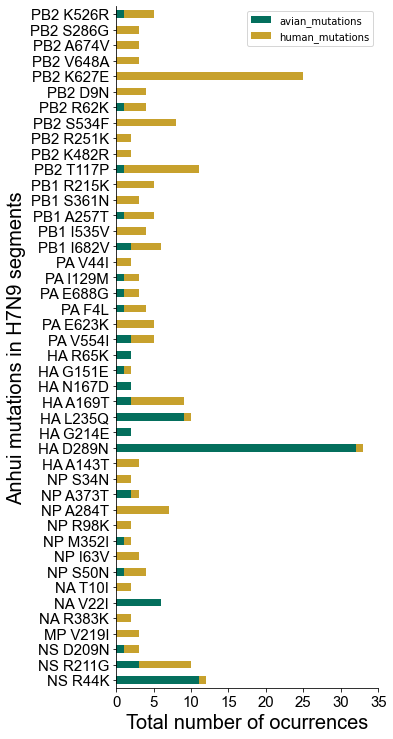

In [434]:
merged_data_anhui_p_values

#new = new_df[((new_df['human_mutations']!= 0) & (new_df['avian_mutations'] > 1))] # & (new_df['human_mutations'] != 0))]# | ((new_df['human_mutations'] > 1) & (new_df['avian_mutations'] != 0))]
anhui_cleaned = merged_data_anhui_p_values.drop(merged_data_anhui_p_values[(merged_data_anhui_p_values['human_mutations'] == 0) & (merged_data_anhui_p_values['avian_mutations'] <= 1)].index)
anhui_cleaned = anhui_cleaned.drop(anhui_cleaned[(anhui_cleaned['avian_mutations'] == 0) & (anhui_cleaned['human_mutations'] <= 1)].index)
len(anhui_cleaned)

anhui_cleaned = anhui_cleaned.sort_values(by = 'order', ascending=False)
df = anhui_cleaned[['site', 'avian_mutations', 'human_mutations']]
df.set_index('site', inplace=True)


font_color = '#000000'
csfont = {'fontname':'Arial'} # title font
hfont = {'fontname':'Arial'} # main font
colors = ["#046F5D", "#C7A12D"]

ax = df.iloc[:, 0:2].plot.barh(align='center', stacked=True, figsize=(5, 10), color=colors)
plt.tight_layout()
ax.set_facecolor('white')

plt.xticks(color=font_color, **hfont, fontsize=15)
plt.yticks(color=font_color, **hfont, fontsize=15)
plt.ylabel('Anhui mutations in H7N9 segments', fontsize=20, **hfont)
plt.xlabel('Total number of ocurrences', fontsize=20, **hfont)
#plt.axes()
plt.xlim(0,35)
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)


plt.savefig('figures/anhui_mutations_fig_6.png', dpi=600, bbox_inches='tight')
plt.savefig('figures/anhui_mutations_fig_6.pdf', dpi=600, bbox_inches='tight') 
plt.savefig('figures/anhui_mutations_fig_6.svg', dpi=600, bbox_inches='tight')
plt.show()





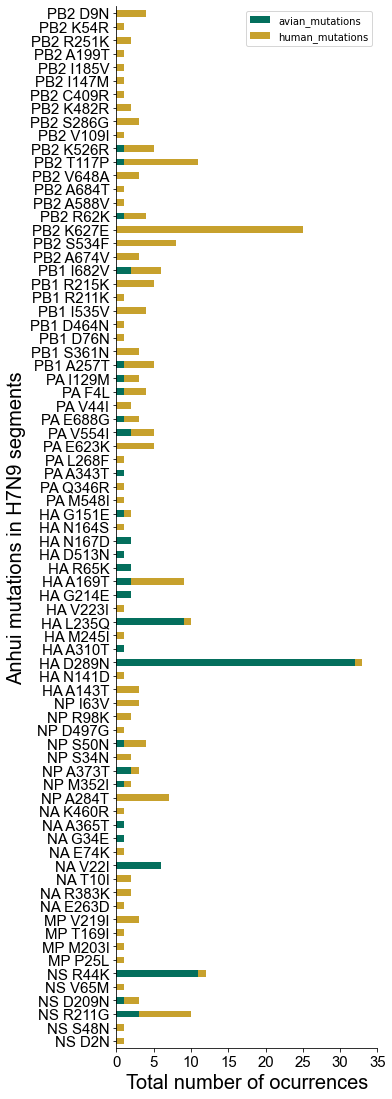

In [435]:
merged_data_anhui_p_values
anhui_cleaned = merged_data_anhui_p_values

len(anhui_cleaned)

anhui_cleaned = anhui_cleaned.sort_values(by = 'order', ascending=False)
df = anhui_cleaned[['site', 'avian_mutations', 'human_mutations']]
df.set_index('site', inplace=True)


font_color = '#000000'
csfont = {'fontname':'Arial'} # title font
hfont = {'fontname':'Arial'} # main font
colors = ["#046F5D", "#C7A12D"]

ax = df.iloc[:, 0:2].plot.barh(align='center', stacked=True, figsize=(5, 15), color=colors)
plt.tight_layout()
ax.set_facecolor('white')

plt.xticks(color=font_color, **hfont, fontsize=15)
plt.yticks(color=font_color, **hfont, fontsize=15)
plt.ylabel('Anhui mutations in H7N9 segments', fontsize=20, **hfont)
plt.xlabel('Total number of ocurrences', fontsize=20, **hfont)
#plt.axes()
plt.xlim(0,35)
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)


plt.savefig('figures/anhui_mutations_sup_fig_6.png', dpi=600, bbox_inches='tight')
plt.savefig('figures/anhui_mutations_sup_fig_6.pdf', dpi=600, bbox_inches='tight') 
plt.savefig('figures/anhui_mutations_sup_fig_6.svg', dpi=600, bbox_inches='tight')
plt.show()






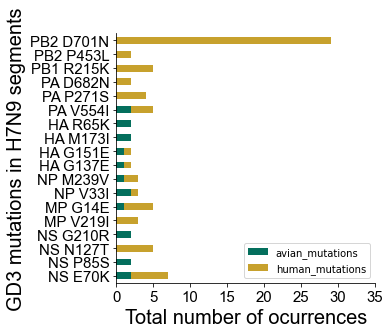

In [436]:
merged_data_gd3_p_values

#new = new_df[((new_df['human_mutations']!= 0) & (new_df['avian_mutations'] > 1))] # & (new_df['human_mutations'] != 0))]# | ((new_df['human_mutations'] > 1) & (new_df['avian_mutations'] != 0))]
gd3_cleaned = merged_data_gd3_p_values.drop(merged_data_gd3_p_values[(merged_data_gd3_p_values['human_mutations'] == 0) & (merged_data_gd3_p_values['avian_mutations'] <= 1)].index)
gd3_cleaned = gd3_cleaned.drop(gd3_cleaned[(gd3_cleaned['avian_mutations'] == 0) & (gd3_cleaned['human_mutations'] <= 1)].index)
len(gd3_cleaned)

gd3_cleaned = gd3_cleaned.sort_values(by = 'order', ascending=False)
df = gd3_cleaned[['site', 'avian_mutations', 'human_mutations']]
df.set_index('site', inplace=True)


font_color = '#000000'
csfont = {'fontname':'Arial'} # title font
hfont = {'fontname':'Arial'} # main font
colors = ["#046F5D", "#C7A12D"]

ax = df.iloc[:, 0:2].plot.barh(align='center', stacked=True, figsize=(5, 4), color=colors)
plt.tight_layout()
ax.set_facecolor('white')

plt.xticks(color=font_color, **hfont, fontsize=15)
plt.yticks(color=font_color, **hfont, fontsize=15)
plt.ylabel('GD3 mutations in H7N9 segments', fontsize=20, **hfont)
plt.xlabel('Total number of ocurrences', fontsize=20, **hfont)
#plt.axes()
plt.xlim(0,35)
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

#legend = plt.legend(loc='lower right',
#       frameon=False,
       #bbox_to_anchor=(0., 1.02, 1., .102), 
       #mode='expand', 
#       ncol=1, 
#       borderaxespad=-.46,
#       prop={'size': 18, 'family':'Arial'})

plt.savefig('figures/gd3_mutations_fig_6.png', dpi=600, bbox_inches='tight')
plt.savefig('figures/gd3_mutations_fig_6.pdf', dpi=600, bbox_inches='tight') 
plt.savefig('figures/gd3_mutations_fig_6.svg', dpi=600, bbox_inches='tight')
plt.show()






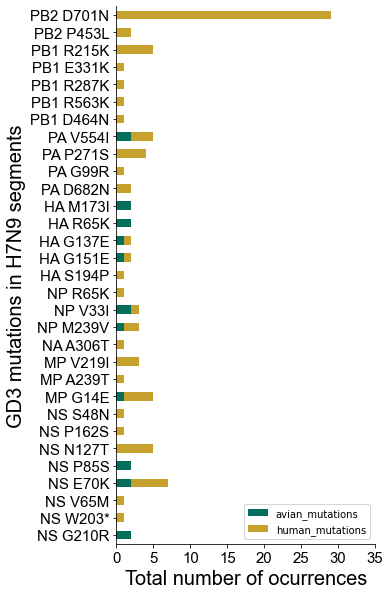

In [437]:
merged_data_gd3_p_values

#new = new_df[((new_df['human_mutations']!= 0) & (new_df['avian_mutations'] > 1))] # & (new_df['human_mutations'] != 0))]# | ((new_df['human_mutations'] > 1) & (new_df['avian_mutations'] != 0))]
gd3_cleaned = merged_data_gd3_p_values.drop(merged_data_gd3_p_values[(merged_data_gd3_p_values['human_mutations'] == 0) & (merged_data_gd3_p_values['avian_mutations'] <= 1)].index)
#gd3_cleaned = gd3_cleaned.drop(gd3_cleaned[(gd3_cleaned['avian_mutations'] == 0) & (gd3_cleaned['human_mutations'] <= 1)].index)
len(gd3_cleaned)

gd3_cleaned = gd3_cleaned.sort_values(by = 'order', ascending=False)
df = gd3_cleaned[['site', 'avian_mutations', 'human_mutations']]
df.set_index('site', inplace=True)


font_color = '#000000'
csfont = {'fontname':'Arial'} # title font
hfont = {'fontname':'Arial'} # main font
colors = ["#046F5D", "#C7A12D"]

ax = df.iloc[:, 0:2].plot.barh(align='center', stacked=True, figsize=(5, 8), color=colors)
plt.tight_layout()
ax.set_facecolor('white')

plt.xticks(color=font_color, **hfont, fontsize=15)
plt.yticks(color=font_color, **hfont, fontsize=15)
plt.ylabel('GD3 mutations in H7N9 segments', fontsize=20, **hfont)
plt.xlabel('Total number of ocurrences', fontsize=20, **hfont)
#plt.axes()
plt.xlim(0,35)
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

#legend = plt.legend(loc='lower right',
#       frameon=False,
       #bbox_to_anchor=(0., 1.02, 1., .102), 
       #mode='expand', 
#       ncol=1, 
#       borderaxespad=-.46,
#       prop={'size': 18, 'family':'Arial'})

plt.savefig('figures/gd3_mutations_sup_fig_6.png', dpi=600, bbox_inches='tight')
plt.savefig('figures/gd3_mutations_sup_fig_6.pdf', dpi=600, bbox_inches='tight') 
plt.savefig('figures/gd3_mutations_sup_fig_6.svg', dpi=600, bbox_inches='tight')
plt.show()





